In [1]:
%%capture
pip install emoji

In [2]:
%%capture
pip install langdetect

In [3]:
%%capture
pip install lime

In [4]:
%%capture
pip install vaderSentiment

In [5]:
%%capture
!pip install imbalanced-learn

In [6]:
%%capture
import nltk
nltk.download('punkt_tab')

In [7]:
%%capture
pip install pandas numpy seaborn

In [8]:
%%capture
pip install textblob

In [9]:
%%capture
pip install wordcloud

In [10]:
%%capture
!pip install mlflow
!pip install datasets

In [11]:
%%capture
pip install xgboost

In [12]:
%%capture
pip install transformers

In [13]:
%%capture
pip install torch

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
 # from transformers import pipeline

from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from nltk.stem import WordNetLemmatizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve,confusion_matrix
from langdetect import detect, DetectorFactory, LangDetectException

# sentiment_analysis_pipeline.py


import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.transformers



from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import chi2

from xgboost import XGBClassifier
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

import warnings
warnings.filterwarnings('ignore')



#import nltk; nltk.download('punkt'); nltk.download('wordnet'); nltk.download('stopwords')

c:\Users\Kenny Ogundana\Downloads\sentiment_analysis\sentiment_api\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
%%capture
#nltk.download('punkt_tab', download_dir='/root/nltk_data')
nltk.download('wordnet', download_dir='/root/nltk_data')
nltk.download('omw-1.4', download_dir='/root/nltk_data')
nltk.download('stopwords', download_dir='/root/nltk_data')

# 1.0 Load Data and Data Understanding

In [16]:
data = pd.read_csv('aliexpressdata.csv')
df = pd.DataFrame(data)
df.head()

,REVIEW_ID,REVIEW_CONTENT,RATING,DATE,COUNTRY
0,6.01E+16,"Same to this one as well, very classy and soft...",5.0,2024-11-08,United States
1,6.01E+16,"Beautiful colors, exactly what I wanted, but ...",4.0,2024-10-15,United States
2,6.01E+16,"This is top notch scarf, so soft and classy no...",5.0,2024-11-08,United States
3,6.01E+16,Item was great; would buy from seller again!,5.0,2024-11-10,United States
4,6.01E+16,Nice item,5.0,2024-10-01,United States


In [17]:
# Print one example where RATING == 1
example_review = df[df['RATING'] == 1]['REVIEW_CONTENT'].iloc[0]
example_review

'I received my package; however, I had to reach out to the seller beforehand regarding their choice of delivery courier, Better Trucks. This company is known for its low ratings and frequent delivery issues. When I raised my concerns with the seller, they completely dismissed them and simply told me to contact my local post office—which makes no sense, as Better Trucks is not a postal service.\n\nAlthough my package did eventually arrive, it was very late in the evening. Due to the seller’s poor customer service and lack of concern for consumer feedback, I will not be ordering from them again. AliExpress used to rely on DHL, a reputable courier, and I’m unsure why that has changed.'

In [18]:
# Print one example where RATING == 3
example_review = df[df['RATING'] == 3]['REVIEW_CONTENT'].iloc[0]
example_review


'I order a 22 and it looks like a 16 inch but other than that it’s very soft. You should but it but if u want a long one grab a 30.'

In [19]:
# Print one example where RATING == 5
example_review = df[df['RATING'] == 5]['REVIEW_CONTENT'].iloc[0]
example_review


'Same to this one as well, very classy and soft, no bad smells. Perfect for my neck too. Vibrant colors '

In [20]:
print(df.shape)

print("--------------")

#check data info
df.info()

(8492, 5)
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8492 entries, 0 to 8491
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   REVIEW_ID       8492 non-null   object 
 1   REVIEW_CONTENT  7869 non-null   object 
 2   RATING          8128 non-null   float64
 3   DATE            8492 non-null   object 
 4   COUNTRY         8492 non-null   object 
dtypes: float64(1), object(4)
memory usage: 331.8+ KB


In [21]:
# mising data
df.isnull().sum()

REVIEW_ID           0
REVIEW_CONTENT    623
RATING            364
DATE                0
COUNTRY             0
dtype: int64

In [22]:
# code to count duplicates
duplicates = df[df.duplicated()]
print("Number of duplicate rows:", len(duplicates))

Number of duplicate rows: 80


In [23]:
# check the data statistics
df.describe(include='all').round(2)

,REVIEW_ID,REVIEW_CONTENT,RATING,DATE,COUNTRY
count,8492,7869,8128.00,8492,8492
unique,6344,7602,NaN,1056,107
top,6.01E+16,Good,NaN,2025-03-24,United Kingdom
freq,600,37,NaN,143,2935
mean,NaN,NaN,4.41,NaN,NaN
std,NaN,NaN,0.98,NaN,NaN
min,NaN,NaN,1.00,NaN,NaN
25%,NaN,NaN,4.00,NaN,NaN
50%,NaN,NaN,5.00,NaN,NaN
75%,NaN,NaN,5.00,NaN,NaN


# 2.0 Quick Exploratory Data Analysis

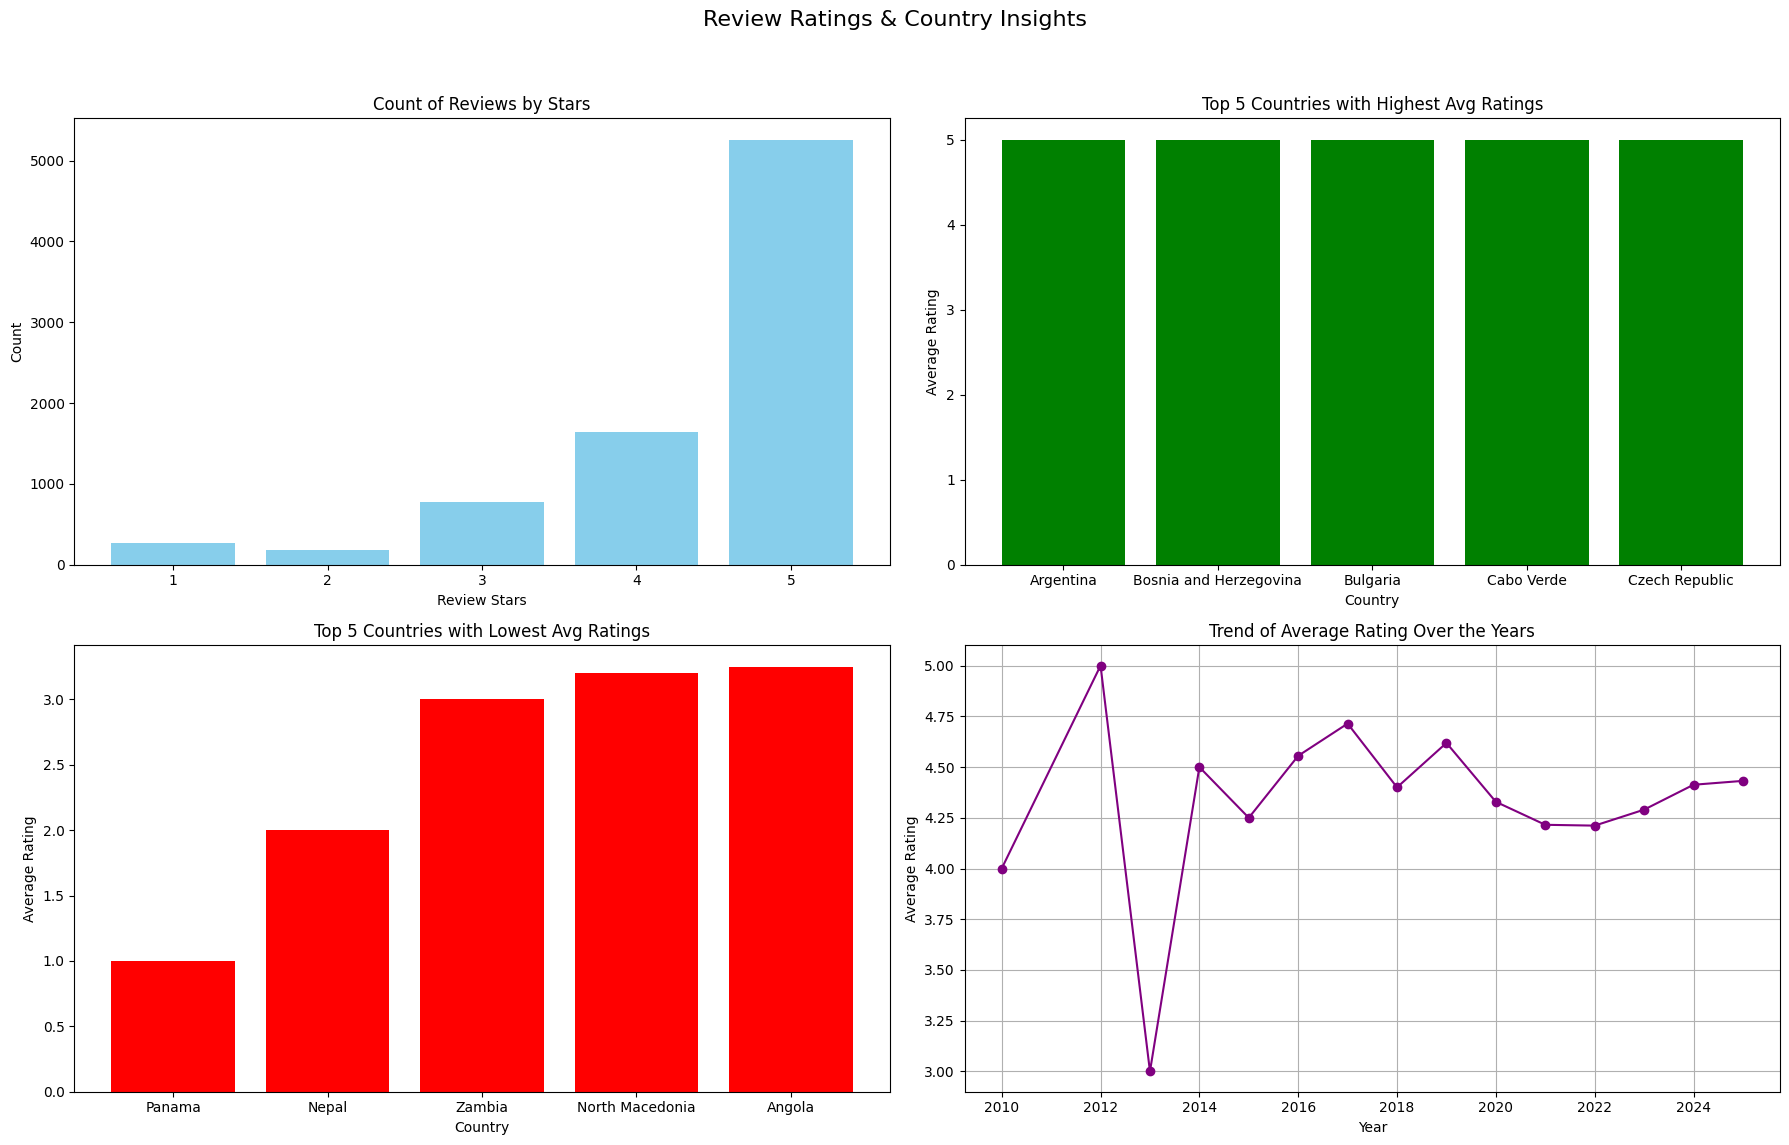

In [24]:
import matplotlib.pyplot as plt

# Prepare figure with 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Review Ratings & Country Insights', fontsize=16)

# --- 1. Count of Reviews by Stars ---
rating_counts = df['RATING'].value_counts().sort_index()
axs[0, 0].bar(rating_counts.index, rating_counts.values, color='skyblue')
axs[0, 0].set_title('Count of Reviews by Stars')
axs[0, 0].set_xlabel('Review Stars')
axs[0, 0].set_ylabel('Count')

# --- 2. Top 5 Countries with Highest Ratings ---
top_5_highest = df.groupby('COUNTRY')['RATING'].mean().nlargest(5)
axs[0, 1].bar(top_5_highest.index, top_5_highest.values, color='green')
axs[0, 1].set_title('Top 5 Countries with Highest Avg Ratings')
axs[0, 1].set_xlabel('Country')
axs[0, 1].set_ylabel('Average Rating')

# --- 3. Top 5 Countries with Lowest Ratings ---
top_5_lowest = df.groupby('COUNTRY')['RATING'].mean().nsmallest(5)
axs[1, 0].bar(top_5_lowest.index, top_5_lowest.values, color='red')
axs[1, 0].set_title('Top 5 Countries with Lowest Avg Ratings')
axs[1, 0].set_xlabel('Country')
axs[1, 0].set_ylabel('Average Rating')

# --- 4. Trend of Average Rating Over the Years ---
if 'DATE' in df.columns:
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
    df['YEAR'] = df['DATE'].dt.year

if 'YEAR' in df.columns:
    yearly_ratings = df.groupby('YEAR')['RATING'].mean()
    axs[1, 1].plot(yearly_ratings.index, yearly_ratings.values, marker='o', linestyle='-', color='purple')
    axs[1, 1].set_title('Trend of Average Rating Over the Years')
    axs[1, 1].set_xlabel('Year')
    axs[1, 1].set_ylabel('Average Rating')
    axs[1, 1].grid(True)
else:
    axs[1, 1].text(0.5, 0.5, "No 'DATE' or 'YEAR' column available", ha='center', va='center', fontsize=12)
    axs[1, 1].set_axis_off()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


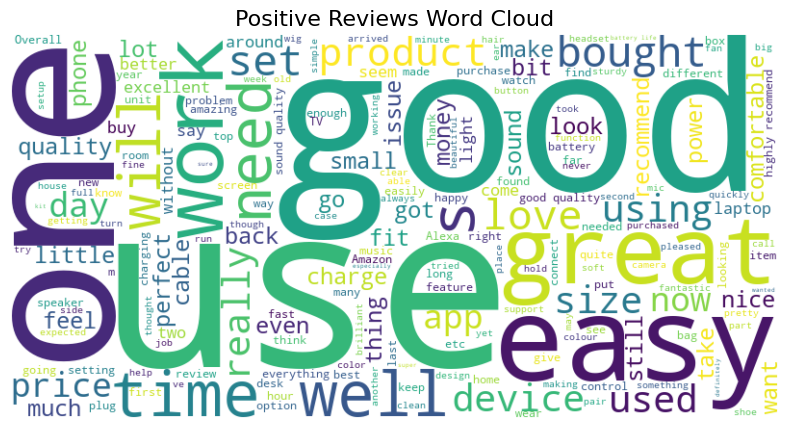

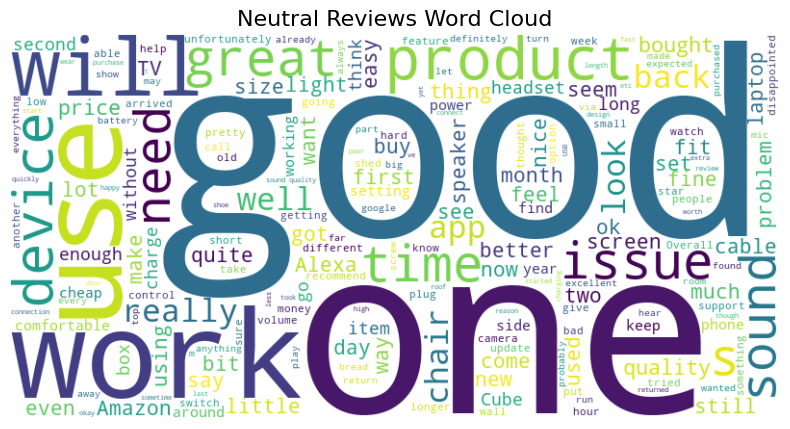

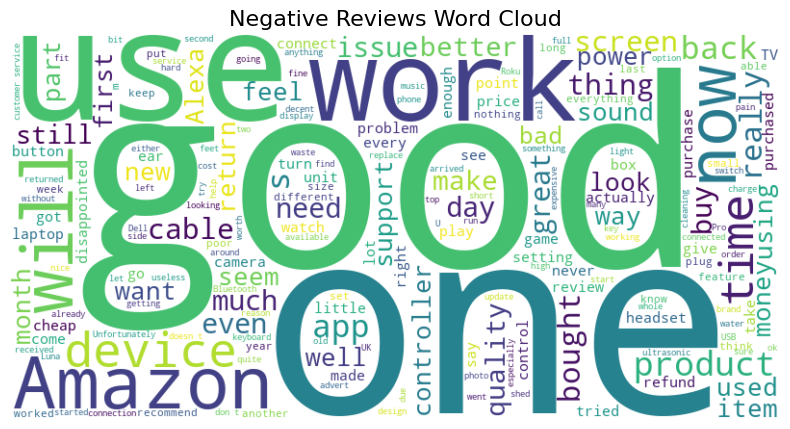

In [25]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Positive Reviews (RATING >= 4)
positive_reviews = df[df['RATING'] >= 4]['REVIEW_CONTENT'].dropna().str.cat(sep=' ')
generate_wordcloud(positive_reviews, "Positive Reviews Word Cloud")

# Neutral Reviews (RATING == 3)
neutral_reviews = df[df['RATING'] == 3]['REVIEW_CONTENT'].dropna().str.cat(sep=' ')
generate_wordcloud(neutral_reviews, "Neutral Reviews Word Cloud")

# Negative Reviews (RATING <= 2)
negative_reviews = df[df['RATING'] <= 2]['REVIEW_CONTENT'].dropna().str.cat(sep=' ')
generate_wordcloud(negative_reviews, "Negative Reviews Word Cloud")

# 🔧 1.0 DATA CLEANING + NEGATION HANDLING

In [26]:
# Ensure consistent language detection
DetectorFactory.seed = 0

# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
stop_words.update({"would", "shall", "could", "might"})
stop_words.discard("not")  # Retain "not" for sentiment analysis

### 1. DATA CLEANING & PREPROCESSING ###

# Function to check if a review is in English
def is_english(text):
    try:
        return detect(text) == "en"
    except LangDetectException:
        return False

# Function to handle negations
def handle_negation(text):
    tokens = word_tokenize(text.lower())
    result = []
    negate = False
    for word in tokens:
        if word in {"not", "no", "never", "n't"}:
            negate = True
            result.append(word)
        elif negate:
            result.append("NOT_" + word)
            negate = False
        else:
            result.append(word)
    return result

# Function to clean text
def clean_text(text):
    text = text.lower()
    text = emoji.replace_emoji(text, replace="")                # Remove emojis
    text = re.sub(r"http\S+", "", text)                         # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)                     # Remove special characters & digits
    tokens = handle_negation(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)

### 2. APPLY TO DATAFRAME ###

# Clean and prepare dataset
df = df.rename(columns={'REVIEW_CONTENT': 'content', 'RATING': 'rating'})
df = df[['content', 'rating']].drop_duplicates().dropna()
df = df[df['content'].apply(is_english)]
df['cleaned_review'] = df['content'].apply(clean_text)

# Create sentiment labels
df["sentiment"] = df["rating"].apply(lambda x: "Positive" if x >= 4 else "Neutral" if x == 3 else "Negative")

df.head()


,content,rating,cleaned_review,sentiment
0,"Same to this one as well, very classy and soft...",5.0,one well classy soft NOT_bad smell perfect nec...,Positive
1,"Beautiful colors, exactly what I wanted, but ...",4.0,beautiful color exactly wanted item defect,Positive
2,"This is top notch scarf, so soft and classy no...",5.0,top notch scarf soft classy NOT_smells perfect...,Positive
3,Item was great; would buy from seller again!,5.0,item great buy seller,Positive
4,Nice item,5.0,nice item,Positive


In [27]:
# # specfy pattern
# pattern = r"[a-zA-Z]+"

# df['char_count'] = df['cleaned_review'].str.count(r"\S")
# df['word_count'] = df['cleaned_review'].str.count(pattern)
# df['avg_word_len'] = df['char_count']/df['word_count'] 
# df.head()

In [32]:

# TF-IDF Vectorization (Unigrams, Bigrams, Trigrams)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, min_df=10)
X = vectorizer.fit_transform(df["cleaned_review"])
y = df["sentiment"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

chi2_scores, _ = chi2(X, y_encoded)
top_features = np.argsort(chi2_scores)[-5000:]
X_selected = X[:, top_features]

In [29]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import LabelEncoder
# from sklearn.feature_selection import chi2
# import numpy as np
# from scipy.sparse import hstack

# # TF-IDF Vectorization (Unigrams, Bigrams, Trigrams)
# vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, min_df=10)
# X_tfidf = vectorizer.fit_transform(df["cleaned_review"])

# # Concatenate with other numerical features (e.g., char_count, word_count, etc.)
# if 'char_count' in df.columns:
#     extra_features = df.loc[:, 'char_count':]  # include all columns from char_count onwards
#     X_combined = hstack([X_tfidf, extra_features])
# else:
#     X_combined = X_tfidf

# # Encode sentiment labels
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(df["sentiment"])

# # Feature selection (Chi-Square Test, Top 5000 TF-IDF Features only)
# # NOTE: Only apply chi2 to the TF-IDF part, not the full combined features
# chi2_scores, _ = chi2(X_tfidf, y)
# top_indices = np.argsort(chi2_scores)[-5000:]
# X_selected_tfidf = X_tfidf[:, top_indices]

# # Final features: selected TF-IDF + additional features (if available)
# if 'char_count' in df.columns:
#     X_final = hstack([X_selected_tfidf, extra_features])
# else:
#     X_final = X_selected_tfidf


In [33]:
### 3. MODEL SELECTION & TRAINING ###
# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Compute Class Weights (Handles Imbalance)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train Logistic Regression Model
#log_reg = LogisticRegression(class_weight=class_weight_dict, max_iter=2000, solver="liblinear", C=1.0)
#log_reg=LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=10, solver='lbfgs', max_iter=200, multi_class='auto', verbose=0, warm_start=False, n_jobs=None)))
#log_reg.fit(X_train, y_train)

from imblearn.over_sampling import SMOTE

# Apply SMOTE to training set only
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

'''model_1 = Pipeline(
    steps=[
        #best base model("classifier", LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None)),
    ("classifier", LogisticRegression())]
)'''
log_reg=LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=10, solver='lbfgs', max_iter=200, multi_class='auto', verbose=0, warm_start=False, n_jobs=None)

# log_reg2=Pipeline(
#     steps=[
#         #best base model("classifier", LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None)),
#     ('vect',TfidfVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(1,3),min_df=10,max_features=10000)),("classifier", LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=10, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None)))]
# )

log_reg.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=200, multi_class='auto')

In [34]:
# ### 3. MODEL SELECTION & TRAINING ###
# # Train-Test Split (80-20)
# #X_train, X_test, y_train, y_test = train_test_split(X_final, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_Selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
# # Compute Class Weights (Handles Imbalance)
# class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
# class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# # Train Logistic Regression Model
# #log_reg = LogisticRegression(class_weight=class_weight_dict, max_iter=2000, solver="liblinear", C=1.0)
# #log_reg=LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=10, solver='lbfgs', max_iter=200, multi_class='auto', verbose=0, warm_start=False, n_jobs=None)))
# #log_reg.fit(X_train, y_train)



# '''model_1 = Pipeline(
#     steps=[
#         #best base model("classifier", LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None)),
#     ("classifier", LogisticRegression())]
# )'''
# log_reg=LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=10, solver='lbfgs', max_iter=200, multi_class='auto', verbose=0, warm_start=False, n_jobs=None)

# # log_reg2=Pipeline(
# #     steps=[
# #         #best base model("classifier", LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None)),
# #     ('vect',TfidfVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(1,3),min_df=10,max_features=10000)),("classifier", LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=10, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None)))]
# # )

# log_reg.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.37      0.33      0.35        80
           1       0.21      0.35      0.27       130
           2       0.92      0.86      0.89      1217

    accuracy                           0.78      1427
   macro avg       0.50      0.51      0.50      1427
weighted avg       0.82      0.78      0.80      1427

AUC Score: 0.7602394891810462


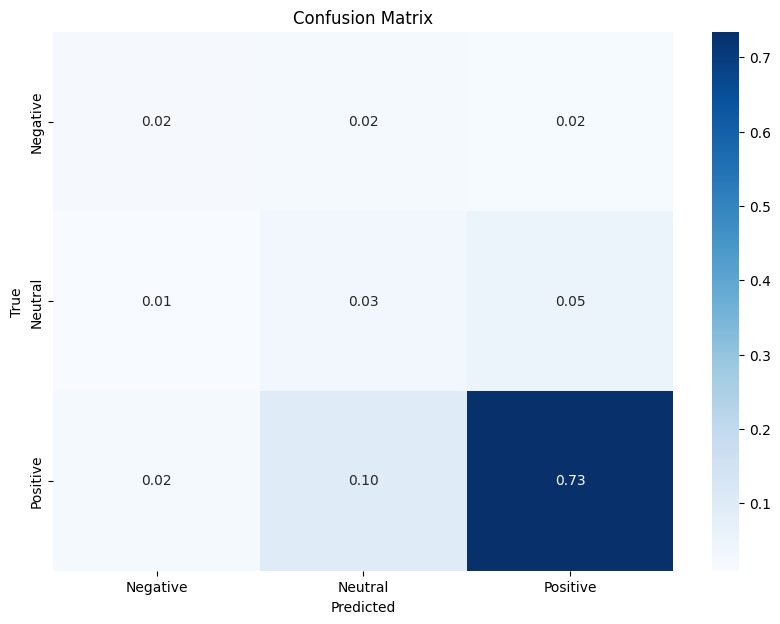

In [37]:
### 4. MODEL EVALUATION ###
# Make Predictions
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)

# Evaluate Performance
print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro"))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize = 'all')
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="0.2f", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Cleaned & Corrected Version (with SMOTE)

              precision    recall  f1-score   support

           0       0.37      0.33      0.35        80
           1       0.21      0.35      0.27       130
           2       0.92      0.86      0.89      1217

    accuracy                           0.78      1427
   macro avg       0.50      0.51      0.50      1427
weighted avg       0.82      0.78      0.80      1427

AUC Score: 0.7602394891810462


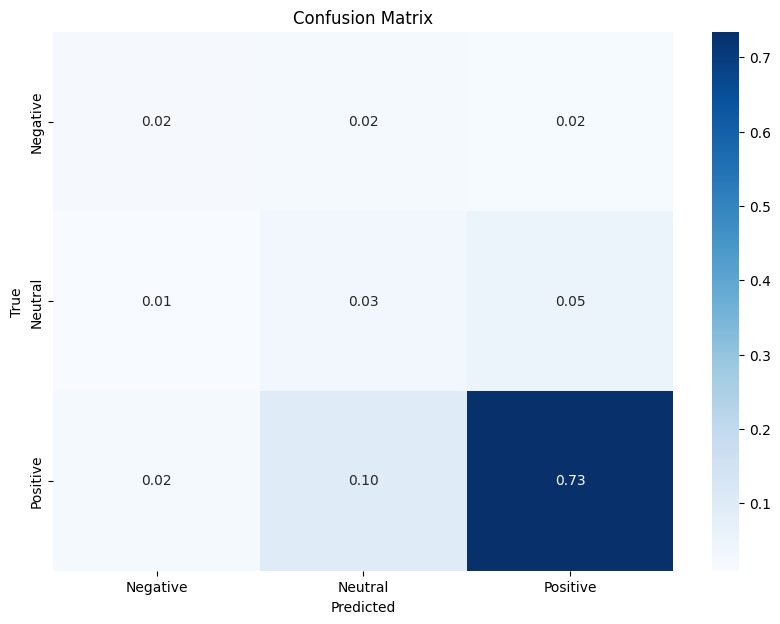

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# 1. TF-IDF Vectorization (Unigrams, Bigrams, Trigrams)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, min_df=10)
X = vectorizer.fit_transform(df["cleaned_review"])
y = df["sentiment"]

# 2. Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 3. Feature Selection using Chi2
chi2_scores, _ = chi2(X, y_encoded)
top_features = np.argsort(chi2_scores)[-5000:]
X_selected = X[:, top_features]

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 5. Apply SMOTE (Oversampling)
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# 6. Compute Class Weights (Optional if using SMOTE)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 7. Train Logistic Regression
log_reg = LogisticRegression(
    penalty='l2', dual=False, tol=0.0001, C=10,
    solver='lbfgs', max_iter=200, multi_class='auto',
    verbose=0, warm_start=False, n_jobs=None
)
log_reg.fit(X_train_resampled, y_train_resampled)

# 8. Evaluate Model
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)

print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro"))

# 9. Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='all')
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="0.2f", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# OVER SAMPLING

              precision    recall  f1-score   support

           0       0.37      0.33      0.35        80
           1       0.21      0.35      0.27       130
           2       0.92      0.86      0.89      1217

    accuracy                           0.78      1427
   macro avg       0.50      0.51      0.50      1427
weighted avg       0.82      0.78      0.80      1427

AUC Score: 0.7602394891810462


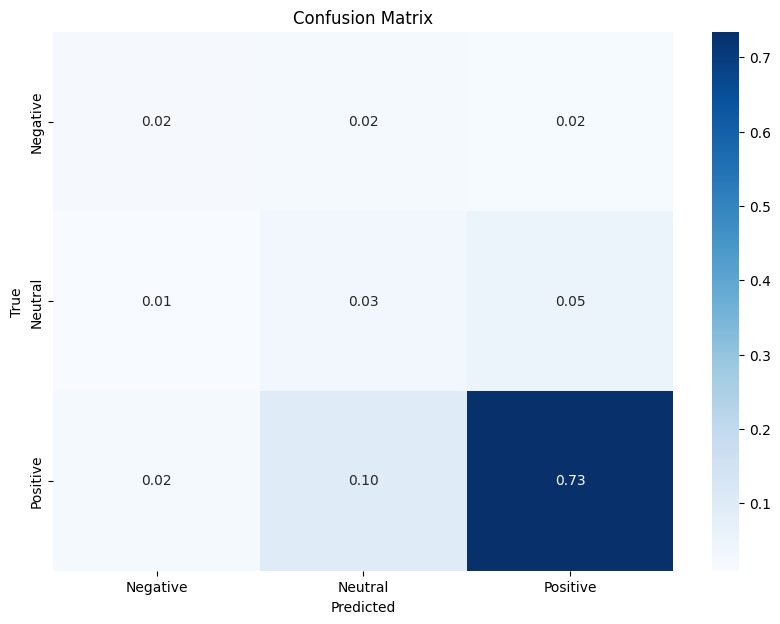

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# 1. TF-IDF Vectorization (Unigrams, Bigrams, Trigrams)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, min_df=10)
X = vectorizer.fit_transform(df["cleaned_review"])
y = df["sentiment"]

# 2. Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 3. Feature Selection using Chi2
chi2_scores, _ = chi2(X, y_encoded)
top_features = np.argsort(chi2_scores)[-5000:]
X_selected = X[:, top_features]

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 5. Apply SMOTE (Oversampling)
sm = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


# 1. Oversampling with SMOTE
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

# 2. Undersampling with RandomUnderSampler
#from imblearn.under_sampling import RandomUnderSampler
#X_train_resampled, y_train_resampled = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)




# 6. Compute Class Weights (Optional if using SMOTE)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 7. Train Logistic Regression
log_reg = LogisticRegression(
    penalty='l2', dual=False, tol=0.0001, C=10,
    solver='lbfgs', max_iter=200, multi_class='auto',
    verbose=0, warm_start=False, n_jobs=None
)
log_reg.fit(X_train_resampled, y_train_resampled)

# 8. Evaluate Model
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)

print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro"))

# 9. Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='all')
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="0.2f", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# UNDER SAMPLING

              precision    recall  f1-score   support

           0       0.26      0.55      0.35        80
           1       0.17      0.52      0.26       130
           2       0.95      0.67      0.78      1217

    accuracy                           0.65      1427
   macro avg       0.46      0.58      0.46      1427
weighted avg       0.84      0.65      0.71      1427

AUC Score: 0.7620691907380485


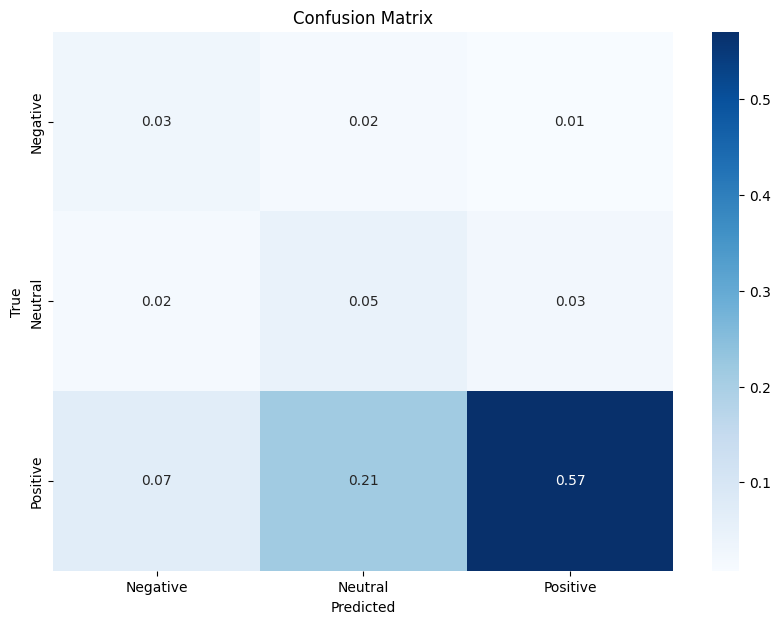

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# 1. TF-IDF Vectorization (Unigrams, Bigrams, Trigrams)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, min_df=10)
X = vectorizer.fit_transform(df["cleaned_review"])
y = df["sentiment"]

# 2. Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 3. Feature Selection using Chi2
chi2_scores, _ = chi2(X, y_encoded)
top_features = np.argsort(chi2_scores)[-5000:]
X_selected = X[:, top_features]

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 5. Apply SMOTE (Oversampling)
#sm = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


# 1. Oversampling with SMOTE
#X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

# 2. Undersampling with RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler
X_train_resampled, y_train_resampled = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)




# 6. Compute Class Weights (Optional if using SMOTE)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 7. Train Logistic Regression
log_reg = LogisticRegression(
    penalty='l2', dual=False, tol=0.0001, C=10,
    solver='lbfgs', max_iter=200, multi_class='auto',
    verbose=0, warm_start=False, n_jobs=None
)
log_reg.fit(X_train_resampled, y_train_resampled)

# 8. Evaluate Model
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)

print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro"))

# 9. Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='all')
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="0.2f", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# HPERPARAMETER TUNNING

In [ ]:
# Hyperparameter Tuning via GridSearchCV (Optional but recommended)
param_grid = {
    'C': [0.1, 0.5, 1.0, 5.0, 6.0, 7.0 , 10.0 ],
    'max_iter': [1000, 2000, 5000],
    'solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best Model from GridSearchCV
log_reg_best = grid_search.best_estimator_
log_reg_best 

Fitting 3 folds for each of 42 candidates, totalling 126 fits


LogisticRegression(C=6.0, max_iter=1000, multi_class='auto', solver='liblinear')

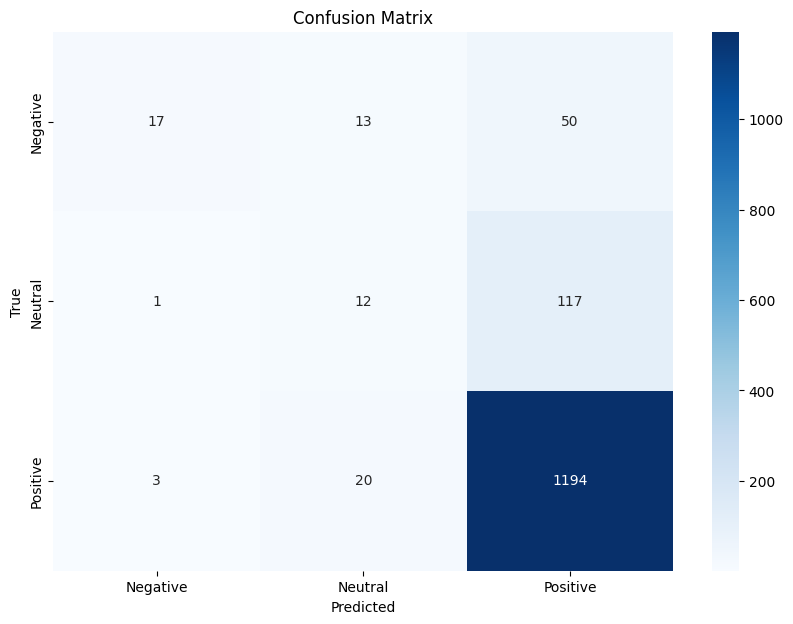

AUC Score: 0.7788238338284558
              precision    recall  f1-score   support

           0       0.81      0.21      0.34        80
           1       0.27      0.09      0.14       130
           2       0.88      0.98      0.93      1217

    accuracy                           0.86      1427
   macro avg       0.65      0.43      0.47      1427
weighted avg       0.82      0.86      0.82      1427



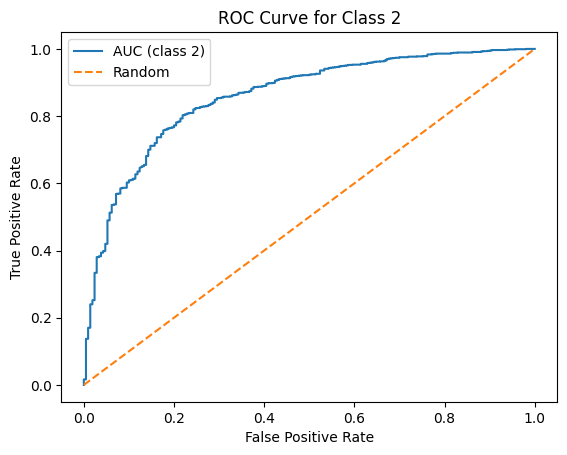

In [ ]:
# Train Logistic Regression Model
log_reg = LogisticRegression(class_weight=class_weight_dict, max_iter=1000, solver="liblinear",multi_class='auto', C=6.0)
#log_reg=LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=6.0, solver='liblinear', max_iter=1000, multi_class='auto', verbose=0, warm_start=False, n_jobs=None)

# # Hyperparameter Tuning via GridSearchCV (Optional but recommended)
# param_grid = {
#     'C': [0.1, 0.5, 1.0, 5.0],
#     'max_iter': [1000, 2000, 5000],
#     'solver': ['liblinear', 'saga']
# }
# grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
# grid_search.fit(X_train, y_train)

# # Best Model from GridSearchCV
# log_reg_best = grid_search.best_estimator_

# Train the best model
log_reg_best.fit(X_train, y_train)

### 4. MODEL EVALUATION ###
# Make Predictions
y_pred = log_reg_best.predict(X_test)
y_prob = log_reg_best.predict_proba(X_test)


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# ROC-AUC Score
auc_score = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
print("AUC Score:", auc_score)

# Classification Report
print(classification_report(y_test, y_pred))

# Plotting AUC-ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 2], pos_label=2)  # Choose one class (Positive)
plt.plot(fpr, tpr, label='AUC (class 2)')
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Class 2')
plt.legend()
plt.show()


Fitting 3 folds for each of 24 candidates, totalling 72 fits


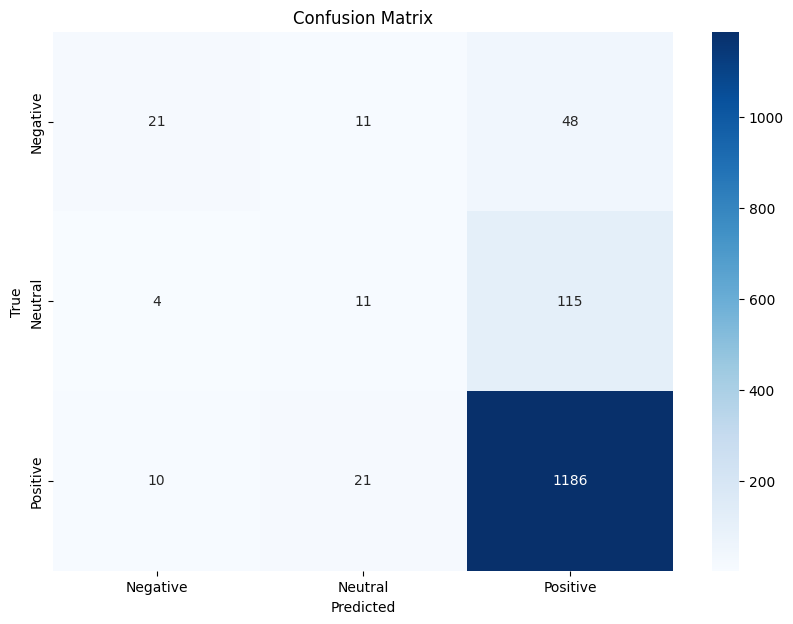

AUC Score: 0.785994867054337
              precision    recall  f1-score   support

           0       0.60      0.26      0.37        80
           1       0.26      0.08      0.13       130
           2       0.88      0.97      0.92      1217

    accuracy                           0.85      1427
   macro avg       0.58      0.44      0.47      1427
weighted avg       0.81      0.85      0.82      1427



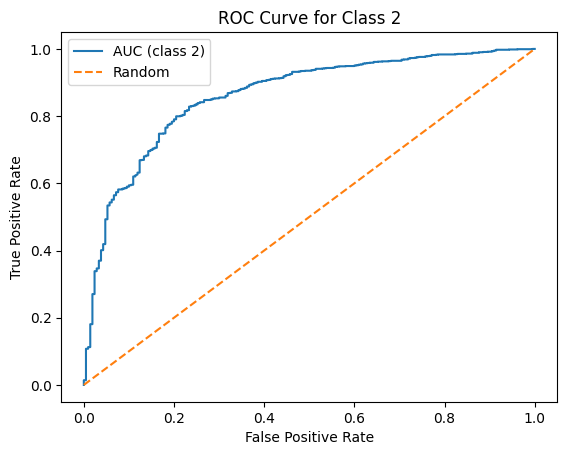

In [ ]:
# Train Logistic Regression Model
log_reg = LogisticRegression(class_weight=class_weight_dict, max_iter=5000, solver="liblinear", C=1.0)

# Hyperparameter Tuning via GridSearchCV (Optional but recommended)
param_grid = {
    'C': [0.1, 0.5, 1.0, 5.0],
    'max_iter': [1000, 2000, 5000],
    'solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best Model from GridSearchCV
log_reg_best = grid_search.best_estimator_

# Train the best model
log_reg_best.fit(X_train, y_train)

### 4. MODEL EVALUATION ###
# Make Predictions
y_pred = log_reg_best.predict(X_test)
y_prob = log_reg_best.predict_proba(X_test)


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# ROC-AUC Score
auc_score = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
print("AUC Score:", auc_score)

# Classification Report
print(classification_report(y_test, y_pred))

# Plotting AUC-ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 2], pos_label=2)  # Choose one class (Positive)
plt.plot(fpr, tpr, label='AUC (class 2)')
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Class 2')
plt.legend()
plt.show()


# WITH MLFLOW Tracking

In [ ]:
# ========================
# 2. FEATURE ENGINEERING
# ========================
#df["SENTIMENT"] = df["RATING"].apply(lambda x: "Positive" if x >= 4 else "Neutral" if x == 3 else "Negative")

vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, min_df=10)
X = vectorizer.fit_transform(df["cleaned_review"])
y = df["sentiment"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

chi2_scores, _ = chi2(X, y_encoded)
top_features = np.argsort(chi2_scores)[-5000:]
X_selected = X[:, top_features]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [ ]:
# ========================
# 3. MODEL TRAINING WITH MLFLOW (LOGISTIC REGRESSION)
# ========================
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

#mlflow.set_experiment("Sentiment Analysis")

# Initialize MLflow
mlflow.set_experiment("Sentiment Analysis")
#mlflow.set_tracking_uri("http://localhost:5000")


mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")

with mlflow.start_run(run_name="LogisticRegression"):
    log_reg = LogisticRegression(class_weight=class_weight_dict, max_iter=2000, solver="liblinear", C=1.0)
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    y_prob = log_reg.predict_proba(X_test)

    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_metric("f1_score", f1_score(y_test, y_pred, average="macro"))
    mlflow.log_metric("precision", precision_score(y_test, y_pred, average="macro"))
    mlflow.log_metric("recall", recall_score(y_test, y_pred, average="macro"))
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro"))
    mlflow.sklearn.log_model(log_reg, "logistic_regression")


2025/04/17 08:39:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: http://127.0.0.1:5000/#/experiments/1/runs/5048803c590e461383d98427b5f3971b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [ ]:
# ========================
# 4. MODEL TRAINING WITH MLFLOW (XGBOOST)
# ========================
with mlflow.start_run(run_name="XGBoost"):
    xgb_clf = XGBClassifier(objective="multi:softprob", eval_metric="mlogloss", use_label_encoder=False)
    xgb_clf.fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)
    y_prob = xgb_clf.predict_proba(X_test)

    mlflow.log_param("model", "XGBoost")
    mlflow.log_metric("f1_score", f1_score(y_test, y_pred, average="macro"))
    mlflow.log_metric("precision", precision_score(y_test, y_pred, average="macro"))
    mlflow.log_metric("recall", recall_score(y_test, y_pred, average="macro"))
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro"))
    mlflow.xgboost.log_model(xgb_clf, "xgboost_model")

2025/04/17 08:40:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://127.0.0.1:5000/#/experiments/1/runs/68ddfb246bd649a08cc3f0551d2c027e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
